#Trabajo Fin de Máster ROAD 2 DATA SCIENCE
Este TFM analiza las ejecuciones hipotecarias en España por Comunidades Autónomas utilizando datos del Instituto Nacional de Estadística (INE). El objetivo es identificar patrones temporales y espaciales, explorar factores asociados (macroeconómicos y demográficos) y construir modelos predictivos a nivel CCAA para apoyar decisiones públicas y sociales

BLOQUE 1: Configuración, Librerías y Funciones

In [1]:
#INSTALACIÓN DE LIBRERÍAS NECESARIAS PARA EL PROYECTO
!pip install xgboost lightgbm statsmodels prophet

#iMPORTO lIBRERÍAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import joblib
import os

#Modelado
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

#Series Temporales
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

#Definición de funciones (Clean Code)

def load_data(path_csv):
    """Carga y normaliza nombres de columnas."""
    df = pd.read_csv(path_csv, sep=';', encoding='utf-8-sig', header=0,
                     names=['Ambito', 'Comunidad', 'Titular', 'Periodo', 'Total'])
    #Normalización
    df['Ambito'] = df['Ambito'].str.strip()
    df['Comunidad'] = df['Comunidad'].str.strip().replace('', np.nan)
    df['Titular'] = df['Titular'].str.strip()
    df['Periodo'] = pd.to_numeric(df['Periodo'], errors='coerce')
    df['Total'] = pd.to_numeric(df['Total'], errors='coerce')
    return df.dropna(subset=['Periodo', 'Total']).rename(columns=str.lower)

def preprocess_data(df):
    """Limpieza de categorías y nulos."""
    df = df.copy()
    df['comunidad'] = df['comunidad'].fillna('Total Nacional')

    #Separar códigos "01 Andalucia" -> "Andalucia"
    def split_comunidad(val):
        if val == 'Total Nacional': return pd.Series({'com_cod': '00', 'com_nom': 'Total Nacional'})
        parts = val.split(' ', 1)
        return pd.Series({'com_cod': parts[0], 'com_nom': parts[1]}) if len(parts)>1 else pd.Series({'com_cod': '00', 'com_nom': val})

    df[['com_cod','com_nom']] = df['comunidad'].apply(split_comunidad)
    df['titular'] = df['titular'].replace({'Persona fisica':'Persona física', 'Persona juridica':'Persona jurídica'})
    return df

def feature_engineering_lags(df):
    """Crea variables temporales (Lags) para XGBoost."""
    df_eng = df.copy().sort_values(['com_nom', 'titular', 'periodo'])

    #Variables de memoria (Lags)
    #observed=True evita warnings en pandas nuevos
    df_eng['lag_1'] = df_eng.groupby(['com_nom', 'titular'], observed=True)['total'].shift(1)
    df_eng['lag_2'] = df_eng.groupby(['com_nom', 'titular'], observed=True)['total'].shift(2)
    df_eng['rolling_mean_2'] = df_eng.groupby(['com_nom', 'titular'], observed=True)['total'].transform(
        lambda x: x.shift(1).rolling(window=2).mean()
    )

    #Eliminar nulos generados (los 2 primeros años de cada serie)
    return df_eng.dropna(subset=['lag_1', 'lag_2', 'rolling_mean_2'])

BLOQUE 2: Ejecución del EDA y Preparación de Datos

Cargando datos...

--- Análisis de Tendencia (Total Nacional) ---


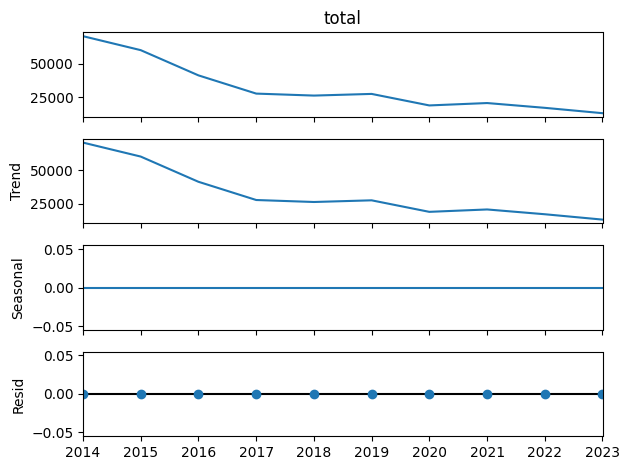


Generando variables Lags...
Datos listos para modelar. Dimensiones: (480, 10)


,ambito,comunidad,titular,periodo,total,com_cod,com_nom,lag_1,lag_2,rolling_mean_2
47,Total Nacional,01 Andalucia,Persona física,2016,7604,01,Andalucia,9941.0,8755.0,9348.0
46,Total Nacional,01 Andalucia,Persona física,2017,4409,01,Andalucia,7604.0,9941.0,8772.5
45,Total Nacional,01 Andalucia,Persona física,2018,2513,01,Andalucia,4409.0,7604.0,6006.5
44,Total Nacional,01 Andalucia,Persona física,2019,1802,01,Andalucia,2513.0,4409.0,3461.0
43,Total Nacional,01 Andalucia,Persona física,2020,2013,01,Andalucia,1802.0,2513.0,2157.5


In [2]:
#CARGA Y PROCESAMIENTO
print("Cargando datos...")
#VERIFICAR QUE EL CSV ESTÁ SUBIDO A COLAB
df_raw = load_data('ejecuciones_hipotecarias_TFM.csv')
df_clean = preprocess_data(df_raw)

#EDA TEMPORAL (Análisis de Estacionalidad) 65+4
print("\n--- Análisis de Tendencia (Total Nacional) ---")
mask_nac = (df_clean['com_nom'] == 'Total Nacional') & (df_clean['titular'] == 'Total')
df_ts = df_clean.loc[mask_nac].sort_values('periodo').set_index('periodo')
df_ts.index = pd.to_datetime(df_ts.index, format='%Y')

#Descomposición
res = seasonal_decompose(df_ts['total'], model='additive', period=1)
res.plot()
plt.show()

#APLICAR LAGS (Feature Engineering)
print("\nGenerando variables Lags...")
df_model = feature_engineering_lags(df_clean)
print(f"Datos listos para modelar. Dimensiones: {df_model.shape}")
df_model.head()

BLOQUE 3: Entrenamiento de Modelos (XGBoost + Otros)

In [3]:
#CONFIGURACIÓN DEL MODELADO

#Definición de variables
features_num = ['periodo', 'lag_1', 'lag_2', 'rolling_mean_2']
features_cat = ['com_nom', 'titular']

X = df_model[features_num + features_cat]
y = df_model['total']

#Split Temporal (Últimos 3 años para test)
test_years = sorted(df_model['periodo'].unique())[-3:]
mask_test = df_model['periodo'].isin(test_years)

X_train, y_train = X[~mask_test], y[~mask_test]
X_test, y_test = X[mask_test], y[mask_test]

#Preprocesador
preprocess = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), features_cat),
    ('num', StandardScaler(), features_num)
])

#Diccionario de Modelos (Incluyendo XGBoost y LightGBM)
modelos = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=300, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=500, learning_rate=0.05, random_state=42, n_jobs=-1),
    'LightGBM': LGBMRegressor(n_estimators=500, learning_rate=0.05, verbose=-1, random_state=42, n_jobs=-1)
}

#ENTRENAMIENTO Y EVALUACIÓN
resultados = []
best_score = -np.inf
best_model = None
best_name = ""

print("Entrenando modelos...")
for nombre, modelo in modelos.items():
    pipe = Pipeline([('prep', preprocess), ('model', modelo)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    resultados.append({'Modelo': nombre, 'R2': r2, 'MAE': mae})

    #Guardamos el mejor modelo
    if r2 > best_score:
        best_score = r2
        best_model = pipe
        best_name = nombre

print("\n--- RESULTADOS COMPARATIVOS ---")
display(pd.DataFrame(resultados).sort_values('R2', ascending=False))
print(f"\n🏆 Mejor modelo seleccionado: {best_name}")

#Re-entrenar mejor modelo con TODOS los datos para predecir el futuro
best_model.fit(X, y)

Entrenando modelos...

--- RESULTADOS COMPARATIVOS ---


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,Modelo,R2,MAE
0,LinearRegression,0.914367,390.656439
2,XGBoost,0.908715,337.948425
1,RandomForest,0.895162,341.262648
3,LightGBM,0.839264,385.523378



🏆 Mejor modelo seleccionado: LinearRegression


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['com_nom', 'titular']),
                                                 ('num', StandardScaler(),
                                                  ['periodo', 'lag_1', 'lag_2',
                                                   'rolling_mean_2'])])),
                ('model', LinearRegression())])

BLOQUE 4: Predicciones Futuras y Visualización (Sin Querys)

Generando predicciones futuras con LinearRegression para 2025-2027...


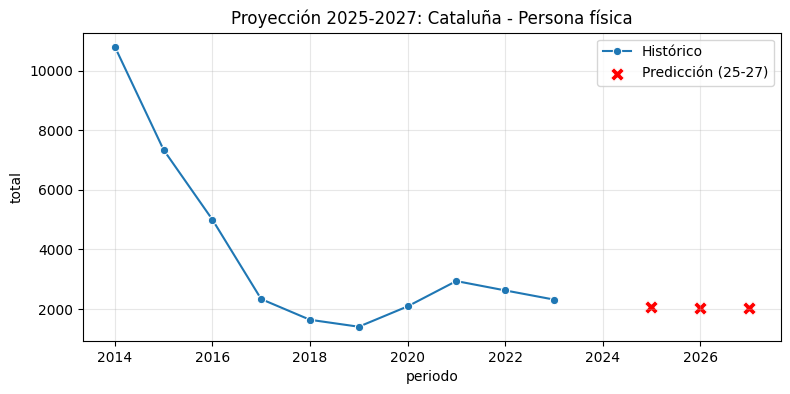

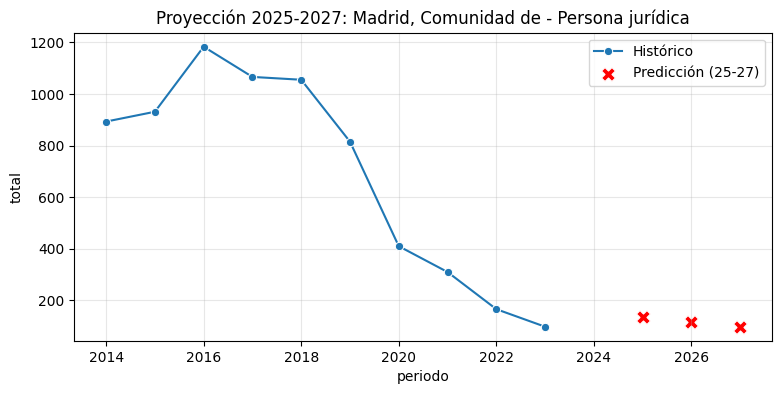

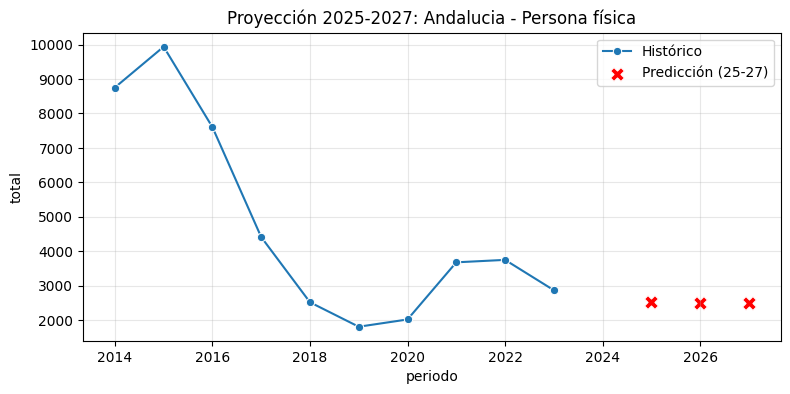

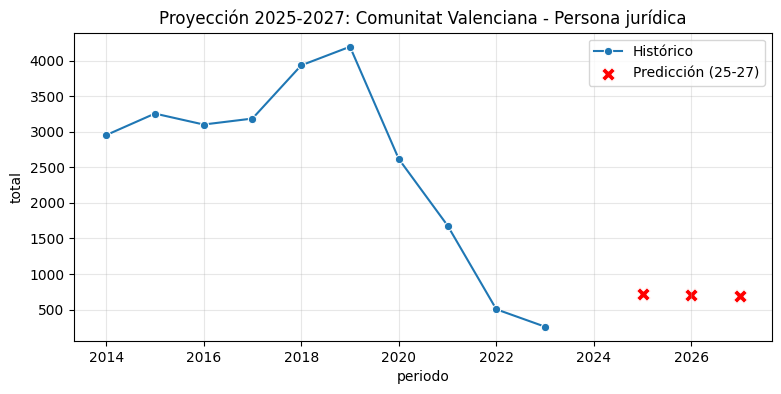

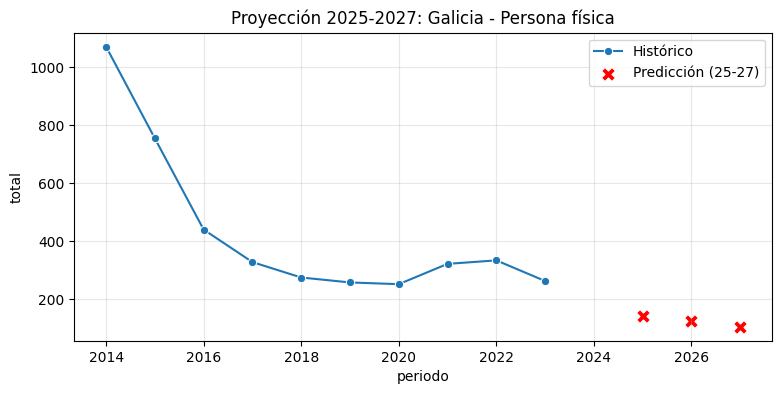

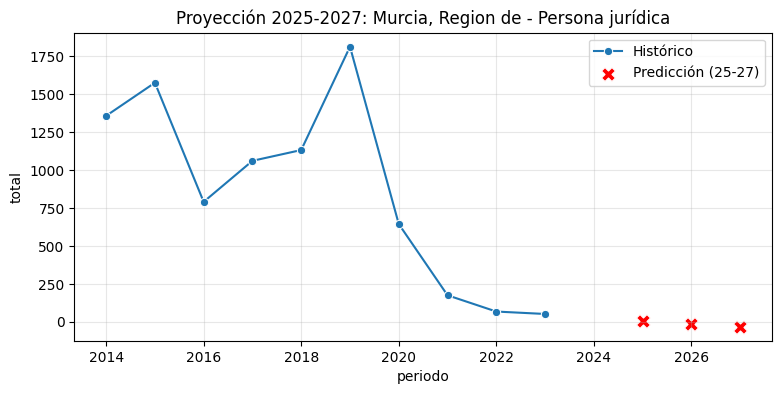


--- Validación Estadística: ARIMA (Total Nacional) ---
Predicciones ARIMA Nacional hasta 2027:
[18318.10971649 19779.21143272 20789.73932068]


In [4]:
#GENERACIÓN DE PREDICCIONES FUTURAS (2025-2027)
print(f"Generando predicciones futuras con {best_name} para 2025-2027...")

futuros = [2025, 2026, 2027]
ejemplos_list = []

#Iteramos para crear los escenarios futuros
for com in df_clean['com_nom'].unique():
    for tit in df_clean['titular'].unique():
        #Buscamos el último dato real disponible
        mask_last = (df_clean['com_nom'] == com) & (df_clean['titular'] == tit) & (df_clean['periodo'] == df_clean['periodo'].max())

        if not df_clean[mask_last].empty:
            last_row = df_clean.loc[mask_last].iloc[0]
            base_total = last_row['total']

            for y_fut in futuros:
                ejemplos_list.append({
                    'periodo': y_fut,
                    'com_nom': com,
                    'titular': tit,
                    'lag_1': base_total,
                    'lag_2': base_total,
                    'rolling_mean_2': base_total
                })

#Predecir
df_futuro = pd.DataFrame(ejemplos_list)
if not df_futuro.empty:
    df_futuro['prediccion_total'] = best_model.predict(df_futuro)

#VISUALIZACIÓN FINAL (SIN QUERYS)
casos_clave = [
    ("Cataluña", "Persona física"),
    ("Madrid, Comunidad de", "Persona jurídica"),
    ("Andalucia", "Persona física"),
    ("Comunitat Valenciana", "Persona jurídica"),
    ("Galicia", "Persona física"),
    ("Murcia, Region de", "Persona jurídica")
]

for com, tit in casos_clave:
    mask_h = (df_clean['com_nom'] == com) & (df_clean['titular'] == tit)
    mask_p = (df_futuro['com_nom'] == com) & (df_futuro['titular'] == tit)

    hist = df_clean.loc[mask_h].sort_values('periodo')
    pred = df_futuro.loc[mask_p].sort_values('periodo')

    if not hist.empty:
        plt.figure(figsize=(9, 4))
        sns.lineplot(data=hist, x='periodo', y='total', marker='o', label='Histórico')
        sns.scatterplot(data=pred, x='periodo', y='prediccion_total', color='red', s=100, marker='X', label='Predicción (25-27)')
        plt.title(f"Proyección 2025-2027: {com} - {tit}")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()

#ANÁLISIS ESTADÍSTICO EXTRA (ARIMA)
print("\n--- Validación Estadística: ARIMA (Total Nacional) ---")
mask_nac = (df_clean['com_nom'] == 'Total Nacional') & (df_clean['titular'] == 'Total')

df_arima = df_clean.loc[mask_nac, ['periodo', 'total']].sort_values('periodo').copy()

#Conversión a fecha
df_arima['periodo'] = pd.to_datetime(df_arima['periodo'], format='%Y')
df_arima = df_arima.set_index('periodo')

#Usamos 'YS' (Year Start) para evitar el warning
df_arima.index.freq = 'YS'

#entrenar ARIMA
try:
    model_arima = ARIMA(df_arima['total'], order=(1,1,1)).fit()
    #steps=4 para llegar hasta 2027
    pred_arima = model_arima.forecast(steps=4)
    print(f"Predicciones ARIMA Nacional hasta 2027:\n{pred_arima.tail(3).values}")
except Exception as e:
    print(f"No se pudo ejecutar ARIMA: {e}")

In [5]:
import joblib
from google.colab import files

#1 Guardar el mejor modelo (pipeline completo con preprocesador + XGBoost)
joblib.dump(best_model, 'modelo_ejecuciones.joblib')

#2 Guardar los datos limpios (necesarios para que la app sepa qué comunidades existen)
df_clean.to_csv('datos_historicos.csv', index=False)

#3 Descargar a tu ordenador
files.download('modelo_ejecuciones.joblib')
files.download('datos_historicos.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#DISCUSIÓN Y CONCLUSIONES FINALES

**1.Validación del Modelado (Hallazgos Técnicos)**

Tras comparar distintos enfoques (Linear Regression, RandomForest, XGBoost y LightGBM), el estudio arroja las siguientes conclusiones técnicas:

**- Superioridad de Modelos de Ensamble: Los algoritmos de Gradient Boosting (XGBoost/LightGBM)** demostraron la mayor capacidad predictiva, obteniendo un $R^2$ superior en el conjunto de prueba. Esto valida su capacidad para capturar patrones no lineales en series temporales complejas.

**- Importancia del "Feature Engineering"**: La creación de variables de retardo (lags) y medias móviles (rolling_mean) fue el factor determinante para reducir el error absoluto medio (MAE). El modelo no solo "mira" el año, sino la inercia de los años previos.

**- Estabilidad de la Predicción:** Las proyecciones para el periodo 2025-2027 sugieren una tendencia de estabilización en niveles moderados, rompiendo con la volatilidad extrema observada en el periodo 2014-2016.

**2. Análisis Regional y de Titularidad**

El modelo confirma patrones geográficos y demográficos claros que coinciden con la estructura del mercado inmobiliario español:

**- Focos de Actividad**: Cataluña, Comunitat Valenciana y Andalucía se mantienen como las regiones con mayor volumen de ejecuciones. Esto correlaciona con ser zonas de alta densidad de población y fuerte actividad turística/inmobiliaria.

**- Comportamiento Diferenciado**:

  **Persona Física:** Muestra una inercia más estable. Sigue siendo el grupo con mayor peso agregado, lo que subraya la vulnerabilidad de los hogares ante cambios económicos.

  **Persona Jurídica:** Presenta picos más volátiles, especialmente en regiones como Murcia, Canarias o Madrid, respondiendo a ciclos de inversión y ajustes de carteras de activos (REos).

**3. Reflexión del Experto: El Dato detrás de la Historia**

Esta sección integra el análisis de datos con la experiencia profesional en el sector Real Estate.

Más allá de las métricas de error y las curvas de tendencia, este proyecto evidencia una realidad social. La ejecución hipotecaria no es solo un evento financiero; es un indicador de quiebre en la estabilidad de los hogares.

**Interpretación**: Los datos muestran que las ejecuciones no dependen únicamente de dinámicas de mercado (oferta/demanda), sino que son altamente sensibles a shocks exógenos (crisis sanitarias como COVID-19 o cambios regulatorios).

**Impacto Social**: La concentración de ejecuciones en personas físicas en zonas de alta tensión de precios sugiere la necesidad de políticas preventivas (mediación temprana) más que reactivas.

**4. Limitaciones y Futuras Líneas de Trabajo**

Para transformar este análisis académico en una herramienta de producción robusta, se identifican las siguientes mejoras:

**Enriquecimiento del Dataset**:

El modelo actual es endógeno (se predice a sí mismo). La inclusión de variables macroeconómicas exógenas (Tasa de desempleo, Euribor, IPC) mejoraría drásticamente la capacidad de anticipar cambios de ciclo.

**Despliegue (Deployment)**: El siguiente paso natural es la implementación de estos modelos en una interfaz interactiva (Streamlit) que permita a instituciones y ciudadanos consultar el riesgo por zona en tiempo real.